## Import libraries and tools

In [22]:
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Model

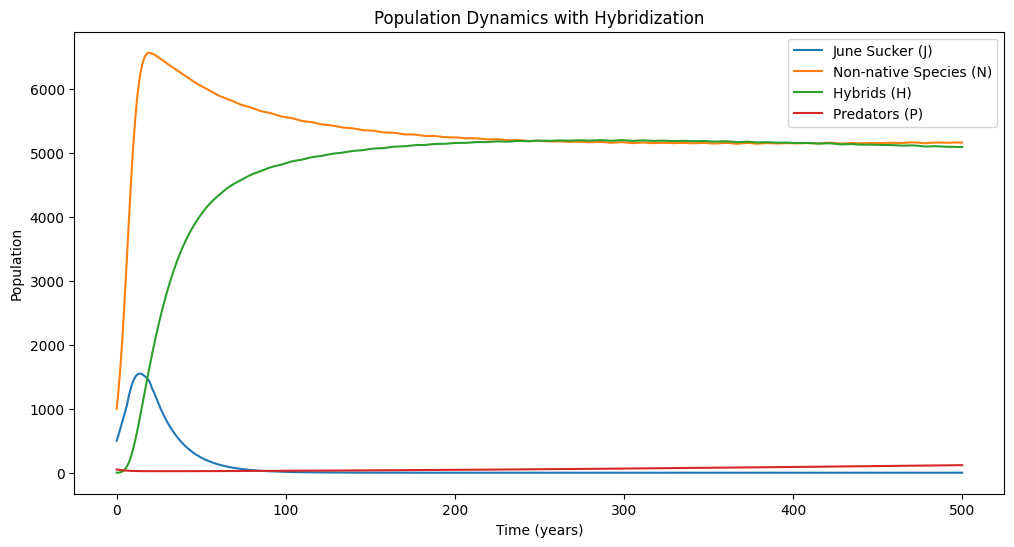

In [23]:
# Updated model parameters including hybrids
r_J = 0.2
r_N = 0.3
r_H = 0.25
K_0 = 10000
c_JN = c_NJ = 1.0
c_JH = c_NH = c_HJ = c_HN = 0.9
beta_J = beta_N = beta_H = 5e-5
s_H = 1e-5
s_P = 1e-5
m_P = 0.1
gamma = 0.5

# Human intervention functions (updated)
def H_J(t):
    return 50 if 5 <= t <= 20 else 0

def H_N(t):
    return -10

def H_H(t):
    return -5

# Carrying capacity function (updated)
def K(t):
    return K_0 + gamma * H_J(t)

# ODE system including hybrids
def ecosystem_model_hybrid(t, y):
    J, N, H, P = y
    dJdt = (
        r_J * J * (1 - (J + c_JN * N + c_JH * H) / K(t))
        - beta_J * J * P
        - s_H * J * N
        + H_J(t)
    )
    dNdt = (
        r_N * N * (1 - (N + c_NJ * J + c_NH * H) / K(t))
        - beta_N * N * P
        - s_H * J * N
        + H_N(t)
    )
    dHdt = (
        s_H * J * N
        + r_H * H * (1 - (H + c_HJ * J + c_HN * N) / K(t))
        - beta_H * H * P
        + H_H(t)
    )
    dPdt = s_P * (J + N + H) * P - m_P * P
    return [dJdt, dNdt, dHdt, dPdt]

# Time span and initial conditions
t_span = (0, 500) # Adjusted time span to determine when equilibrium takes place
t_eval = np.linspace(*t_span, 500)
initial_conditions = [500, 1000, 0, 50]  # J_0, N_0, H_0, P_0

# Solving the ODE system
solution = solve_ivp(ecosystem_model_hybrid, t_span, initial_conditions, t_eval=t_eval)

# Extracting results
J_t, N_t, H_t, P_t = solution.y

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(solution.t, J_t, label='June Sucker (J)')
plt.plot(solution.t, N_t, label='Non-native Species (N)')
plt.plot(solution.t, H_t, label='Hybrids (H)')
plt.plot(solution.t, P_t, label='Predators (P)')
plt.title('Population Dynamics with Hybridization')
plt.xlabel('Time (years)')
plt.ylabel('Population')
plt.legend()
plt.show()

## Calculate equilibrium points of final combined model

In [24]:
# Redefine the system with no time dependence for equilibrium analysis
def equilibrium_system(y, t=0):
    J, N, H, P = y
    dJdt = (
        r_J * J * (1 - (J + c_JN * N + c_JH * H) / K_0)
        - beta_J * J * P
        - s_H * J * N
        + 50 # Assuming constant stocking of June suckers
    )
    dNdt = (
        r_N * N * (1 - (N + c_NJ * J + c_NH * H) / K_0)
        - beta_N * N * P
        - s_H * J * N
        - 10  # Assuming constant removal of non-native species
    )
    dHdt = (
        s_H * J * N
        + r_H * H * (1 - (H + c_HJ * J + c_HN * N) / K_0)
        - beta_H * H * P
        - 5  # Assuming constant removal of hybrids
    )
    dPdt = s_P * (J + N + H) * P - m_P * P
    return [dJdt, dNdt, dHdt, dPdt]

# Solve for equilibrium
J_eq, N_eq, H_eq, P_eq = fsolve(equilibrium_system, initial_conditions)

# Print the results
print(f"Equilibrium June Sucker Population (J):        {J_eq}")
print(f"Equilibrium Non-native Species Population (N): {N_eq}")
print(f"Equilibrium Hybrid Population (H):             {H_eq}")
print(f"Equilibrium Predator Population (P):           {P_eq}")

Equilibrium June Sucker Population (J):        -245.60430962500055
Equilibrium Non-native Species Population (N): 32.43469781599387
Equilibrium Hybrid Population (H):             19.97531368896398
Equilibrium Predator Population (P):           3.3645717464827046e-09


## Calculate when equilibrium points occur

In [25]:
# Equilibrium points
equilibrium_values = [0, 32.43, 19.98, 0]  # Suppose June Sucker equilibrium is 0 instead of -245.60
tolerance = 1e-2  # Define a tolerance for "close to equilibrium"

# Time points and species populations from the solution
time_points = solution.t
populations = solution.y  # J_t, N_t, H_t, P_t

# Find the time when each species hits equilibrium
def find_equilibrium_time(time_points, population, equilibrium_value, tolerance):
    for t, pop in zip(time_points, population):
        if abs(pop - equilibrium_value) <= tolerance:
            return t
    return None  # Return None if equilibrium is not reached

equilibrium_times = [
    find_equilibrium_time(time_points, species_pop, eq_value, tolerance)
    for species_pop, eq_value in zip(populations, equilibrium_values)
]

# Display results
species_names = ["June Sucker (J)", "Non-native Species (N)", "Hybrid (H)", "Predator (P)"]
for species, eq_time in zip(species_names, equilibrium_times):
    if eq_time is not None:
        print(f"{species} reaches equilibrium at t = {eq_time:.2f}")
    else:
        print(f"{species} does not reach equilibrium within the simulation time.")


June Sucker (J) reaches equilibrium at t = 236.47
Non-native Species (N) does not reach equilibrium within the simulation time.
Hybrid (H) does not reach equilibrium within the simulation time.
Predator (P) does not reach equilibrium within the simulation time.


## Create phase plots

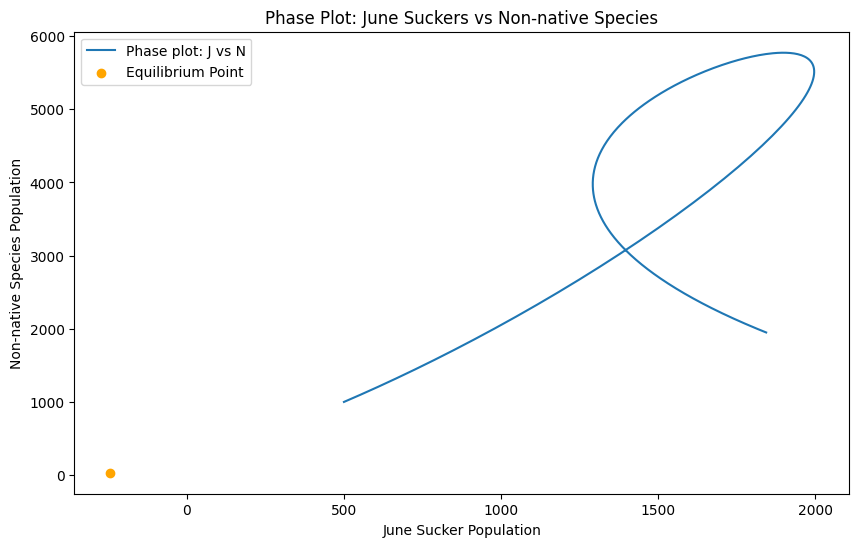

In [26]:
# Time span for the simulation
time = np.linspace(0, 100, 500)

# Solve the ODEs
solution = odeint(equilibrium_system, initial_conditions, time)

# Extract the populations from the solution
J, N, H, P = solution.T

# Plot J vs N (Phase plot)
plt.figure(figsize=(10, 6))
plt.plot(J, N, label="Phase plot: J vs N")

# Plot equilibrium point 
plt.scatter([J_eq], [N_eq], color='orange', zorder=5, label="Equilibrium Point")

# Add labels and title
plt.xlabel("June Sucker Population")
plt.ylabel("Non-native Species Population")
plt.title("Phase Plot: June Suckers vs Non-native Species")
plt.legend()

plt.show()


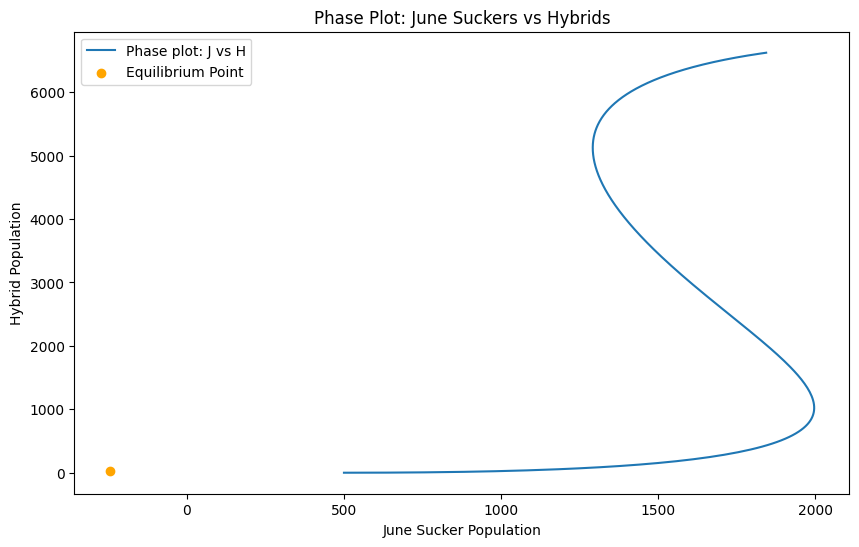

In [27]:
# Plot J vs H (Phase plot)
plt.figure(figsize=(10, 6))
plt.plot(J, H, label="Phase plot: J vs H")

# Plot equilibrium point 
plt.scatter([J_eq], [H_eq], color='orange', zorder=5, label="Equilibrium Point")

# Add labels and title
plt.xlabel("June Sucker Population")
plt.ylabel("Hybrid Population")
plt.title("Phase Plot: June Suckers vs Hybrids")
plt.legend()

plt.show()

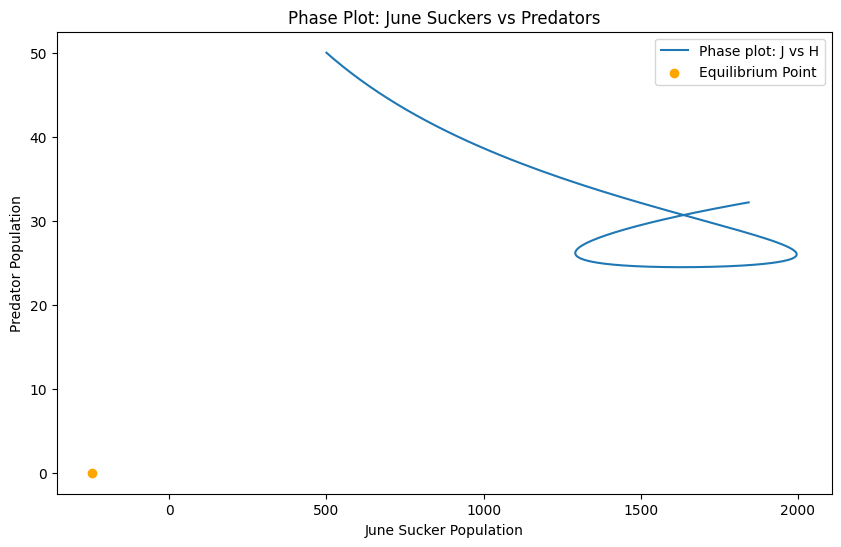

In [28]:
# Plot J vs P (Phase plot)
plt.figure(figsize=(10, 6))
plt.plot(J, P, label="Phase plot: J vs H")

# Plot equilibrium point 
plt.scatter([J_eq], [P_eq], color='orange', zorder=5, label="Equilibrium Point")

# Add labels and title
plt.xlabel("June Sucker Population")
plt.ylabel("Predator Population")
plt.title("Phase Plot: June Suckers vs Predators")
plt.legend()

plt.show()